In [59]:
import sys
from tqdm import tqdm, trange

from numba import njit
import numpy as np
import scipy
from matplotlib import pyplot as plt

source = "../source"
sys.path.append(source)

from data import gen_rand_seq


import publication

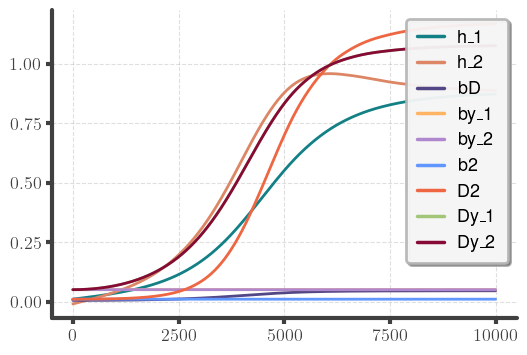

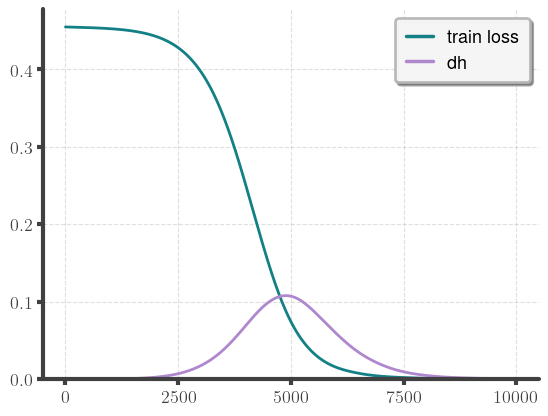

In [ ]:
@njit
def der(t, z, eta_h_1, eta_h_2, eta_a, eta_b, N, y11, y12, y22):
    """Right hand side of the ode system."""
    h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2 = z
    h_mean = (h_1 + h_2) / 2
    h2_mean = (h_1**2 + h_2**2) / 2
    Dy_mean = (Dy_1 + Dy_2) / 2
    by_mean = (by_1 + by_2) / 2
    hb_mean = (h_1 * by_1 + h_2 * by_2) / 2
    Dhy_mean = (h_1 * Dy_1 + h_2 * Dy_2) / 2
    hy2_mean_1 = (h_1 * y11 + h_2 * y12) / 2
    hy2_mean_2 = (h_1 * y12 + h_2 * y22) / 2
    return [
        -eta_h_1 * (1 / 2) * (bD + h_1 * D2 - Dy_1),
        -eta_h_2 * (1 / 2) * (bD + h_2 * D2 - Dy_2),
        -eta_b * (1 / N) * (bD + h_mean * D2 - Dy_mean)
        - eta_a * (1 / N) * (h2_mean * bD + h_mean * b2 - hb_mean),
        -eta_b * (1 / N) * (by_1 + h_mean * Dy_1 - (y11 + y12) / 2),
        -eta_b * (1 / N) * (by_2 + h_mean * Dy_2 - (y22 + y12) / 2),
        -eta_b * (2 / N) * (b2 + h_mean * bD - by_mean),
        -eta_a * (2 / N) * (h2_mean * D2 + h_mean * bD - Dhy_mean),
        -eta_a * (1 / N) * (h2_mean * Dy_1 + h_mean * by_1 - hy2_mean_1),
        -eta_a * (1 / N) * (h2_mean * Dy_2 + h_mean * by_2 - hy2_mean_2),
    ]


def get_train_loss(h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2, y11, y22):
    return 0.5 * (
        b2
        + D2 * (h_1**2 + h_2**2) / 2
        + (y11 + y22) / 2
        + 2 * bD * (h_1 + h_2) / 2
        - 2 * (h_1 * Dy_1 + h_2 * Dy_2) / 2
        - 2 * (by_1 + by_2) / 2
    )


y_1, y_2 = 1, 1
N = 1
y11, y12, y22 = y_1**2, y_1 * y_2, y_2**2

lr = 0.001
eta_h_1, eta_h_2, eta_a, eta_b = lr, 2 * lr, 1 * lr, 0 * lr

gain = 0.01
theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = 0, 0, 0, 0, 0
theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = (
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
)  # These may depend on y11, y12, y22
h_1_0, h_2_0, D2_0, b2_0 = (gain, -gain, gain, gain)
bD_0, by_1_0, by_2_0, Dy_1_0, Dy_2_0 = (
    theta_bD * np.sqrt(b2_0 * D2_0),
    theta_by_1 * np.sqrt(b2_0 * y_1**2),
    theta_by_2 * np.sqrt(b2_0 * y_2**2),
    theta_Dy_1 * np.sqrt(D2_0 * y_1**2),
    theta_Dy_2 * np.sqrt(D2_0 * y_2**2),
)

epochs = 10000

sol = scipy.integrate.solve_ivp(
    der,
    [0, epochs],
    [h_1_0, h_2_0, bD_0, by_1_0, by_2_0, b2_0, D2_0, Dy_1_0, Dy_2_0],
    args=(eta_h_1, eta_h_2, eta_a, eta_b, N, y11, y12, y22),
    dense_output=True,
)
t = np.linspace(0, epochs, epochs)
z = sol.sol(t)
h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2 = z
train_loss = get_train_loss(h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2, y11, y22)

publication.set_color_mixed()
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(t, h_1, label="h_1")
plt.plot(t, h_2, label="h_2")
plt.plot(t, bD, label="bD")
plt.plot(t, by_1, label="by_1")
plt.plot(t, by_2, label="by_2")
plt.plot(t, b2, label="b2")
plt.plot(t, D2, label="D2")
plt.plot(t, Dy_1, label="Dy_1")
plt.plot(t, Dy_2, label="Dy_2")
plt.legend()
publication.plt_show()
publication.set_color_mixed()
plt.plot(t, train_loss, label="train loss")
publication.skip_colors(3)
plt.plot(t, (h_2 - h_1) ** 2, label="dh")
plt.ylim(0)
plt.legend()
publication.plt_show()

In [141]:
max_len = 5
thresh = 0.1

problem = lambda seq: np.sum(seq) % 2
train_data = [
    x for n in range(1, max_len + 1) for x in gen_rand_seq(n=n, symbols=[0, 1])
]

lr = 0.001

gain = 0.1
theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = (
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
)  # These may depend on y11, y12, y22


epochs = 10000


indicators_same = []
indicators_diff = []
train_loss = np.zeros(epochs)
for x in tqdm(train_data):
    for y in train_data:
        i, j = len(x), len(y)

        ## Data variables
        N = 1
        y_1, y_2 = problem(x), problem(y)
        y11, y12, y22 = y_1**2, y_1 * y_2, y_2**2

        ## Initial parameters
        # C = gain ** np.min((i, j))
        h_1_0, h_2_0, D2_0, b2_0 = (
            gain**i,
            -(gain**j),
            gain,
            gain,
        )  ## Replace with normal distributions
        bD_0, by_1_0, by_2_0, Dy_1_0, Dy_2_0 = (
            theta_bD * np.sqrt(b2_0 * D2_0),
            theta_by_1 * np.sqrt(b2_0 * y_1**2),
            theta_by_2 * np.sqrt(b2_0 * y_2**2),
            theta_Dy_1 * np.sqrt(D2_0 * y_1**2),
            theta_Dy_2 * np.sqrt(D2_0 * y_2**2),
        )

        ## Effective learning rates
        eta_h_1, eta_h_2, eta_a, eta_b = lr * i, lr * j, lr, lr

        ## Simulate
        sol = scipy.integrate.solve_ivp(
            der,
            [0, epochs],
            [h_1_0, h_2_0, bD_0, by_1_0, by_2_0, b2_0, D2_0, Dy_1_0, Dy_2_0],
            args=(eta_h_1, eta_h_2, eta_a, eta_b, N, y11, y12, y22),
            dense_output=True,
        )
        t = np.linspace(0, epochs, epochs)
        z = sol.sol(t)
        h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2 = z

        indicator = np.abs(h_2 - h_1) > thresh
        if y_1 == y_2:
            indicators_same.append(indicator)
        else:
            indicators_diff.append(indicator)

        train_loss += get_train_loss(
            h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2, y11, y22
        )

sum_same = np.sum(np.array(indicators_same), axis=0)
sum_diff = np.sum(np.array(indicators_diff), axis=0)

n_pairs = len(train_data) ** 2

plt.figure(figsize=(4, 3))
publication.set_color_mixed()
plt.plot(t, train_loss / np.max(train_loss), label="Training loss")
# plt.plot(t, test_loss, label="Validation loss")
publication.skip_colors(1)
plt.plot(t, (sum_same + sum_diff) / n_pairs, label="Splits total")
publication.skip_colors(1)
plt.plot(t, sum_same / n_pairs, label="Splits same")
plt.plot(t, sum_diff / n_pairs, label="Splits diff")

# plt.legend()
publication.plt_show(save_path="theory_n_states")

 31%|███       | 19/62 [00:03<00:06,  6.17it/s]